 # Импорты и установка библиотек

In [1]:
# устанавливаем дополнительные библиотеки, которых не хватает
# mmh3 - библиотека для hash function
import sys
!{sys.executable} -m pip install mmh3

In [2]:
import os
import datetime
import requests
import base64

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tqdm.auto import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import mmh3
import warnings
warnings.simplefilter('ignore')

# Датасет для экспериментов

1. Скачиваем датасет

In [3]:
# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

# файл скачивается и будет называться data_kion.zip (это архив)
with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

2. Распаковываем архив из 3 файлов

In [4]:
!unzip data_kion.zip

Archive:  data_kion.zip
   creating: data_kion/
  inflating: __MACOSX/._data_kion    
  inflating: data_kion/users.csv     
  inflating: __MACOSX/data_kion/._users.csv  
  inflating: data_kion/items.csv     
  inflating: __MACOSX/data_kion/._items.csv  
  inflating: data_kion/interactions_df.csv  
  inflating: __MACOSX/data_kion/._interactions_df.csv  


# 📺 Данные: датасет КИОН

https://github.com/MobileTeleSystems/RecTools/tree/main/datasets/KION

- **просмотры** фильмов и сериалов в приложении онлайн-кинотеатра KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [5]:
interactions = pd.read_csv('data_kion/interactions_df.csv', parse_dates=["last_watch_dt"])
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

## Мы будем использовать ТОЛЬКО данные `interactions` = пользователь `user_id` посмотрел фильм `item_id` столько-то секунд `total_dur` в такую дату `last_watch_dt`
- с датой last_watch_dt
- длительностью просмотра total_dur
- % просмотра watched_pct

In [6]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).dt.date
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [7]:
max_date = interactions['last_watch_dt'].max()

In [8]:
week1 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]
week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week3 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=21)]

In [9]:
week1.shape, week2.shape, week3.shape

((490982, 5), (888543, 5), (1272366, 5))

In [10]:
week1 = week1.groupby('user_id', as_index=False).agg({'total_dur': sum})
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})
week3 = week3.groupby('user_id', as_index=False).agg({'total_dur': sum})

In [11]:
print(week1.shape)
upper = week1['total_dur'].mean() + 3 * week1['total_dur'].std()
week1 = week1[week1['total_dur'] <= upper]
print(week1.shape)

print(week2.shape)
upper = week2['total_dur'].mean() + 3 * week2['total_dur'].std()
week2 = week2[week2['total_dur'] <= upper]
print(week2.shape)

print(week3.shape)
upper = week3['total_dur'].mean() + 3 * week3['total_dur'].std()
week3 = week3[week3['total_dur'] <= upper]
print(week3.shape)

(185907, 2)
(184041, 2)
(279129, 2)
(276067, 2)
(353361, 2)
(351837, 2)


In [12]:
def salt_generator():
  """Func for generating random salt if user does not set salt"""
  salt = os.urandom(8)
  return base64.b64encode(salt).decode('ascii')


def get_salt(user_salt=None, save_salt=True):
  """Func for setting salt"""

  if user_salt:
      salt = user_salt
  else:
      salt = salt_generator()

  if save_salt:
      today = datetime.today().date().strftime('%Y-%m-%d')
      with open(f"salt_{today}.txt", 'w') as f:
          f.write(salt)
  return salt


In [13]:
import mmh3

def get_hash(df, col='user_id',
             salt=None, n_groups=2,
             return_salt=False):
    """
    Делим пользователей на 2 группы по хэшу.
    """
    if salt is None:
        salt = salt_generator()

    ids = df[col].astype(str) + salt

    hashes = ids.map(lambda x: mmh3.hash128(x) & ((1 << 128) - 1))

    groups = (hashes % n_groups).astype(int)
    groups.name = 'group'

    if return_salt:
        return groups, salt
    return groups

In [14]:
week1['group'] = get_hash(week1, col='user_id', n_groups=2, salt='hw1_week1')
week2['group'] = get_hash(week2, col='user_id', n_groups=2, salt='hw1_week2')
week3['group'] = get_hash(week3, col='user_id', n_groups=2, salt='hw1_week3')

In [15]:
def bootstrap_mean_diff_ci(group_a, group_b, alpha=0.05,
                           iters=1000, return_distribution=False):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(group_a, replace=True, size=len(group_a)).mean()
            -
            np.random.choice(group_b, replace=True, size=len(group_b)).mean()
        )

    if return_distribution:
        return values, np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # [1.05; 2.35]
    else:
        return np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)])


In [16]:
def get_p_value(dist):
    dist = np.asarray(dist)

    p_right = (dist >= 0).mean()
    p_left  = (dist <= 0).mean()

    return 2 * min(p_right, p_left)


In [17]:
def get_effect(week1, N=1000, iters=1000, effect_list = [0.02]):
  power_and_effect = []

  for effect in effect_list:

      power = []

      for i in tqdm(range(N)):

          week1['group'] = get_hash(week1, col='user_id', n_groups=2, salt=str(i))

          group_a = week1[week1['group'] == 0]['total_dur'].values
          group_b = week1[week1['group'] == 1]['total_dur'].values

          left_side, right_side = bootstrap_mean_diff_ci(
              group_a,
              group_b * (1 + effect),
              iters=iters,
              return_distribution=False
          )

          power.append(not (left_side <= 0 <= right_side))


      power_and_effect.append({
          "effect": effect,
          "power": power
      })

      return power_and_effect


In [18]:
power_and_effect_week1 = get_effect(week1, N=1000, iters=1000)
power_and_effect_week2 = get_effect(week2, N=1000, iters=1000)
power_and_effect_week3 = get_effect(week3, N=1000, iters=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
power_and_effect = [
    power_and_effect_week1[0],
    power_and_effect_week2[0],
    power_and_effect_week3[0]
]

shapes = [
    week1.shape[0],
    week2.shape[0],
    week3.shape[0],
]

In [20]:
def plot_power(power_list, shapes, color='pink', title='', verbose=True):
    """
    Строит график мощности по списку power_dict'ов
    {"effect": float, "power": list_of_bools}
    """

    x = shapes
    e = power_list[0]["effect"]
    y = [np.mean(d["power"]) for d in power_list]

    if verbose:
        for effect, power in zip(x, y):
            print(f"вероятность, что бутстрап найдет отличие в {e * 100:.0f}% при размере выборки {effect} = "
                  f"{power:.2f}")

    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y, marker='o', color=color)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{effect}" for effect in x])
    ax.grid(False)
    ax.set_ylim([0, 1.1])
    plt.title(title)

    return fig, ax

вероятность, что бутстрап найдет отличие в 2% при размере выборки 184041 = 0.67
вероятность, что бутстрап найдет отличие в 2% при размере выборки 276067 = 0.84
вероятность, что бутстрап найдет отличие в 2% при размере выборки 351837 = 0.80


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Power depends on sample size with effect 0.02'}>)

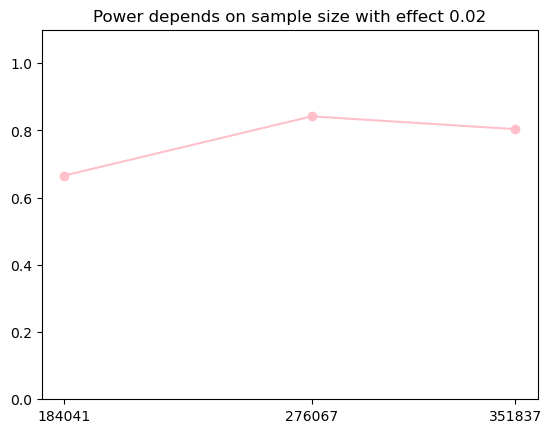

In [21]:
plot_power(power_and_effect, shapes, title='Power depends on sample size with effect 0.02')

In [23]:
(
    week1.total_dur.std(),
    week2.total_dur.std(),
    week3.total_dur.std()
)

(24293.569913732506, 29658.024042774523, 45312.880511370095)

In [25]:
mask_first_week = (interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7))
mask_second_week = (
    (interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)) & 
    (interactions['last_watch_dt'] < max_date - datetime.timedelta(days=7))
)
mask_third_week3 = (
    (interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=21)) & 
    (interactions['last_watch_dt'] < max_date - datetime.timedelta(days=7))
)


(
    interactions[mask_first_week].total_dur.std(),
    interactions[mask_second_week].total_dur.std(),
    interactions[mask_third_week3].total_dur.std()
)

(35666.043543697706, 36913.04095608534, 97362.10230159608)

```
Вывод:
```
Для A/B теста оптимальны 2 недели и ~276 тыс. пользователей - это дает максимальную мощность 84%. Падение мощности на 3 неделе связано с ростом дисперсии данных, что затрудняет обнаружение эффекта. Увеличение дисперсии может быть вызвано включением в выборку более "случайных" пользователей с нерегулярным поведением, а также накоплением различных внешних факторов влияния за длительный период (особенно 3ей недели).
